In [163]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio, display
from scipy import signal

# audio example
samples, sr = librosa.load("audio_examples/voice.wav", sr=44100)

# 2 seconds
samples = samples[sr: sr * 3]

## **Shelving Filters**

### **First-Order Design**

First-order shelf filters can be constructed based on a **first-order allpass filter**, similar to those explored in IIR filter designs. The transfer function for a first-order shelf filter is given by:

$$
\large
H(z) = 1 + \frac{H_0}{2} [1 \pm A(z)]
\large
$$

- The **+** sign is used for **low-frequency shelving** (LF),
- The **−** sign is used for **high-frequency shelving** (HF).

The allpass filter $A(z) $ is defined as:

$$
\large
A(z) = \frac{z^{-1} + c_{b/c}}{1 + c_{b/c} \cdot z^{-1}}
\large
$$

<br>

with the following **difference equation**:


$$
\large
x_h(n) = x(n) - c_{b/c} \cdot x_h(n-1)
\large
$$

$$
\large
y_{ap}(n) = c_{b/c} \cdot x(n) + x_h(n-1)
\large
$$

$$
\large
y(n) = \frac{H_0}{2}[x(n) \pm y_{ap}(n)] + x(n)
\large
$$
<br>

Where $c_{b/c}$ is either the **boost** or **cut** and $H_0$, the gain. These parameters are calculated as follows:

#### **Gain Parameter $H_0 $**

The gain parameter $H_0 $ is derived from the gain $G $ (in dB) as follows:

$$
\large
H_0 = V_0 - 1 \quad \text{where} \quad V_0 = 10^{\frac{G}{20}}
\large
$$

For a **low-shelf filter**, the cutoff parameters are:

- **Boost**:
  
  $$
  \large
  c_b = \frac{\tan\left(\frac{\pi f_c}{f_s}\right) - 1}{\tan\left(\frac{\pi f_c}{f_s}\right) + 1}
  \large
  $$

- **Cut**:

  $$
  \large
  c_c = \frac{\tan\left(\frac{\pi f_c}{f_s}\right) - V_0}{\tan\left(\frac{\pi f_c}{f_s}\right) + V_0}
  \large
  $$

For a **high-shelf filter**, the cutoff parameters are:

- **Boost**:

  $$
  \large
  c_b = \frac{\tan\left(\frac{\pi f_c}{f_s}\right) - 1}{\tan\left(\frac{\pi f_c}{f_s}\right) + 1}
  \large
  $$

- **Cut**:

  $$
  \large
  c_c = \frac{V_0 \cdot \tan\left(\frac{\pi f_c}{f_s}\right) - 1}{V_0 \cdot \tan\left(\frac{\pi f_c}{f_s}\right) + 1}
  \large
  $$


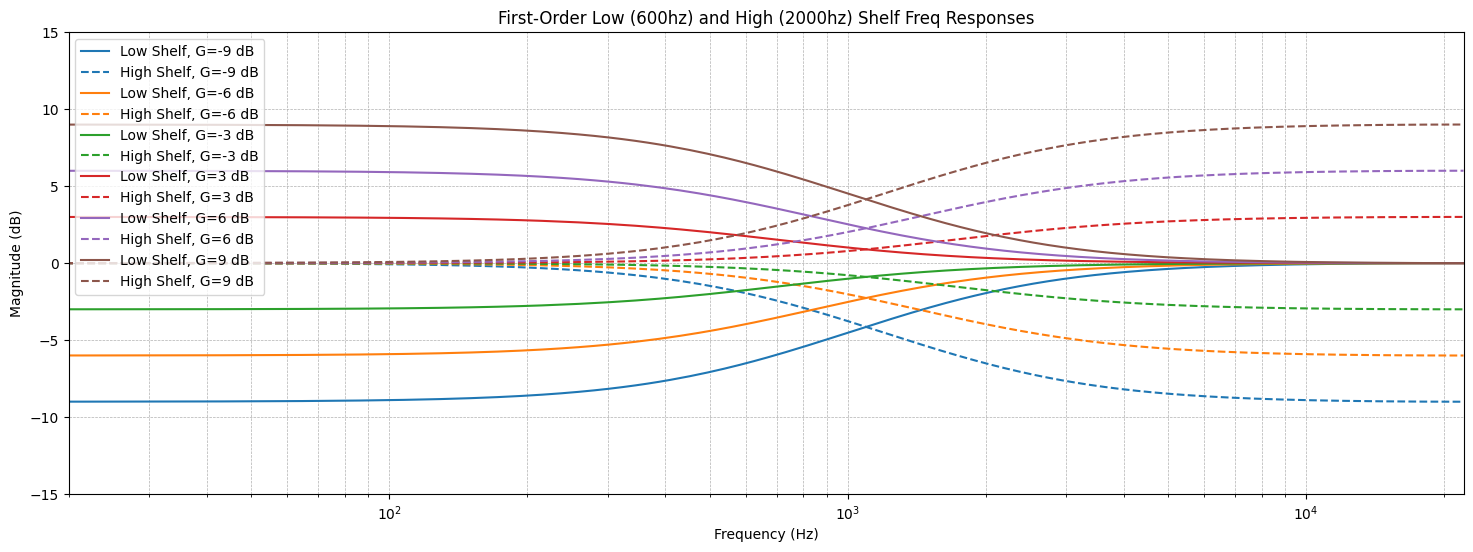

Original


First-Order Low Shelf @ gain=9, cutoff=600


First-Order High Shelf @ gain=9, cutoff=2000


In [164]:
def gain_param(G):
    V_0 = 10 ** (G / 20)
    
    return V_0 - 1, V_0

def shelf_params(V_0, fc, fs):
    tan = np.tan(np.pi * fc / fs)

    boost = (tan - 1)  / (tan + 1) 
    low_cut = (tan - V_0) / (tan + V_0)
    hi_cut = (V_0 * tan - 1) / (V_0 * tan + 1)


    return {
        "high": {
            "boost": boost,
            "cut": hi_cut,
        },
        "low": {
            "boost":  boost,
            "cut" : low_cut,
        }
    }

def shelf_filter(x, G, fc, fs, t='low'):
    N = len(x)
    x_h = np.zeros(N)
    y = np.zeros(N)

    gain_type = 'boost' if G >= 0 else 'cut'
    H_0, V_0 = gain_param(G)
    c = shelf_params(V_0, fc, fs)[t][gain_type]
    
    for n in range(N):
        if n == 0:
            x_h[n] = x[n]
            ap_y = c * x_h[n] + x_h[n]  
        else:
            x_h[n] = x[n] - c * x_h[n - 1]
            ap_y = c * x_h[n] + x_h[n - 1]
        
        if t == 'low':
            y[n] = 0.5 * H_0 * (x[n] + ap_y) + x[n]
        else:
            y[n] = 0.5 * H_0 * (x[n] - ap_y) + x[n]

    return y

def shelf_freq_response(G, fc, fs, t = 'low', n_points=1024):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)
    
    gain_type = 'boost' if G >= 0 else 'cut'
    H_0, V_0 = gain_param(G)
    c = shelf_params(V_0, fc, fs)[t][gain_type]

    for i, omega in enumerate(w):
        z = np.exp(1j * omega)
        A_z = (z ** -1 + c) / (1 + c * z ** -1)

        if t == 'low':
            H[i] = 1 + H_0 * 0.5 *(1 + A_z)
        else:
            H[i] = 1 + H_0 * 0.5 *(1 - A_z)

    freqs = (w * fs) / (np.pi * 2)

    # returning the db mags here for simplicity
    return freqs, 20 * np.log10(np.abs(H)) 

G = 10 # in DB
cutoffs=[600, 2000]
fs = sr # sample rate from opened file
gains = [-9, -6, -3, 3, 6, 9]  #  db
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  



low_shelved = shelf_filter(samples, G, cutoffs[0], fs, t = 'low')
high_shelved = shelf_filter(samples, G, cutoffs[1], fs, t = 'high')

plt.figure(figsize=(18, 6))  

for G, color in zip(gains, colors):
    freqs, H_low_db = shelf_freq_response(G, cutoffs[0], fs, t='low')
    plt.plot(freqs, H_low_db, linestyle='-', color=color, label=f"Low Shelf, G={G} dB")
    freqs, H_high_db = shelf_freq_response(G, cutoffs[1], fs, t='high')
    plt.plot(freqs, H_high_db, linestyle='--', color=color, label=f"High Shelf, G={G} dB")
    

plt.xscale('log')
plt.xlim(20, fs / 2)  
plt.ylim(-15, 15)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title(f"First-Order Low ({cutoffs[0]}hz) and High ({cutoffs[1]}hz) Shelf Freq Responses")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

print("Original")
display(Audio(samples, rate=fs))
print(f"First-Order Low Shelf @ gain={G}, cutoff={cutoffs[0]}")
display(Audio(low_shelved, rate=fs))
print(f"First-Order High Shelf @ gain={G}, cutoff={cutoffs[1]}")
display(Audio(high_shelved, rate=fs))

## **Canonical Second-Order Shelf**

Second-order shelf filters build upon the principles of first-order designs but introduce additional coefficients to enhance the filter's ability to shape the frequency response. By using second-order structures, these filters can achieve a more pronounced shelf and a smoother transition around the cutoff frequency. The design incorporates coefficients $b_0$, \$b_1$, $b_2$, $a_1$, and $a_2$, which adjust the filter's gain and slope characteristics for both boost and cut configurations in low and high shelving modes. 


| Filter     | $b_0$                                 | $b_1$                                   | $b_2$                                 | $a_1$                                | $a_2$                                  |
|------------|---------------------------------------|-----------------------------------------|---------------------------------------|--------------------------------------|----------------------------------------|
| Low Shelf Boost    | $\large\frac{1+\sqrt{2V_0}K + V_0K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(V_0K^2-1)}{1 + \sqrt{2}K +K^2}$ | $\large\frac{1 - \sqrt{2V_0}K + V_0K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(K^2 - 1)}{1 + \sqrt{2}K +K^2}$  | $\large\frac{1 - \sqrt{2}K + K^2}{1 + \sqrt{2} K + K ^2}$ |
| Low Shelf Cut    | $\large\frac{V_0(1+\sqrt{2}K + K^2)}{V_0 + \sqrt{2V_0} K + K ^2}$ | $\large \frac{2V_0(K^2-1)}{V_0 + \sqrt{2V_0} K + K ^2}$ | $\large\frac{V_0(1 - \sqrt{2}K + K^2)}{V_0 + \sqrt{2V_0} K + K ^2}$ | $\large \frac{2(K^2 - V_0)}{V_0 + \sqrt{2V_0} K + K ^2}$  | $\large\frac{V_0 - \sqrt{2V_0} K + K ^2}{V_0 + \sqrt{2V_0} K + K ^2}$ |
High Shelf Boost    | $\large\frac{V_0+\sqrt{2V_0}K + K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(K^2 - V_0)}{1 + \sqrt{2}K +K^2}$ | $\large\frac{V_0 - \sqrt{2V_0}K + V_0K^2}{1 + \sqrt{2} K + K ^2}$ | $\large \frac{2(K^2 - 1)}{1 + \sqrt{2}K +K^2}$  | $\large\frac{1 - \sqrt{2}K + K^2}{1 + \sqrt{2} K + K ^2}$ |
| Low Shelf Cut    | $\large\frac{V_0(1+\sqrt{2}K + K^2)}{1 + \sqrt{2V_0} K + V_0K ^2}$ | $\large \frac{2V_0(K^2-1)}{1 + \sqrt{2V_0} K + V_0K ^2}$ | $\large\frac{V_0(1 - \sqrt{2}K + K^2)}{1 + \sqrt{2V_0} K + V_0K ^2}$ | $\large \frac{2(V_0K^2 - 1)}{1 + \sqrt{2V_0} K + V_0K ^2}$  | $\large\frac{1 - \sqrt{2V_0} K + V_0K ^2}{1 + \sqrt{2V_0} K + V_0K ^2}$ |
<br>
<center>
with $ \large K = tan(\pi f_c/f_s)\large$ and $\large V_0 = 10^{G/20} \large $
</center>

<br><br>

The **difference equation** for this filter incorporates the new coefficients to achieve a second-order response:
<br><br>

$$
\large
y(n) = b_0 x(n) + b_1 x(n-1) + b_2 x(n-2) - a_1 y(n-1) - a_2 y(n-2)
\large
$$

<br>

The **transfer function**, representing the filter’s frequency response, is given by:
<br>

$$
\large
H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}
\large
$$
<br>

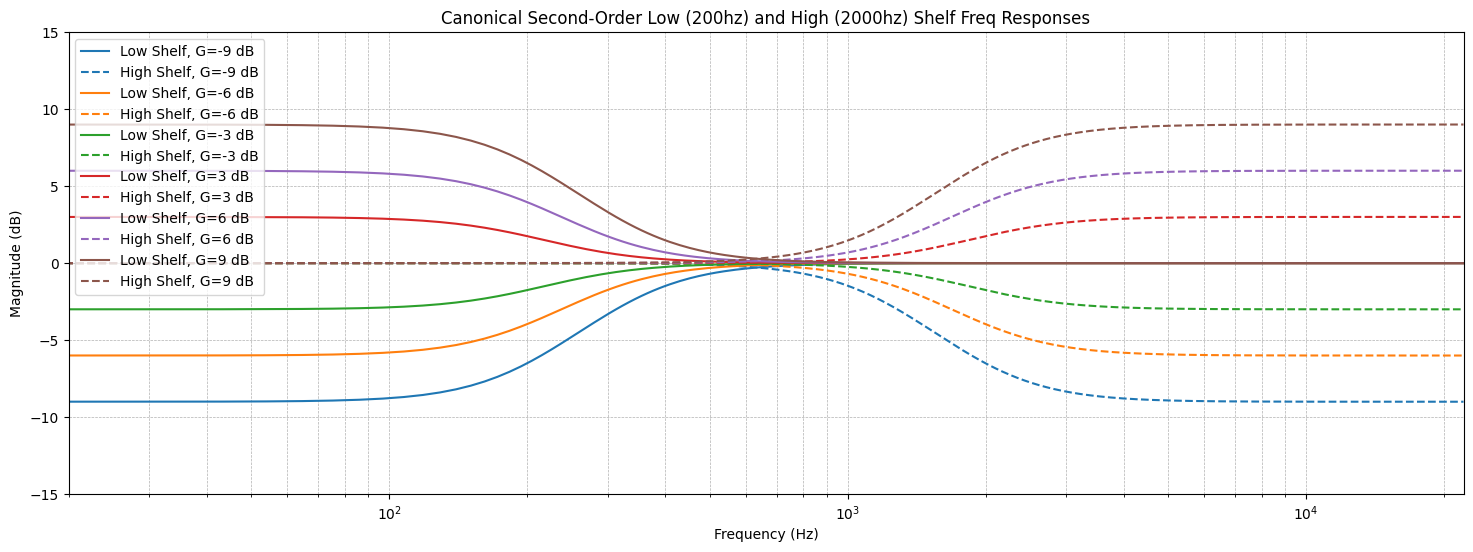

Second-order Low Shelf G=-10, FC=200


Second-order High Shelf G=-10, FC=2000


In [162]:
def low_boost_coeff(K, V_0):
    den = 1 + np.sqrt(2) * K + K**2
    
    b0 = (1 + np.sqrt(2 * V_0) * K + V_0 * K**2) / den
    b1 = (2 * (V_0 * K**2 - 1)) / den
    b2 = (1 - np.sqrt(2 * V_0) * K + V_0 * K**2) / den
    a1 = (2 * (K**2 - 1)) / den
    a2 = (1 - np.sqrt(2) * K + K**2) / den

    return b0, b1, b2, a1, a2

def low_cut_coeff(K, V_0):
    den = V_0 + np.sqrt(2 * V_0) * K + K**2

    b0 = (V_0 * (1 + np.sqrt(2) * K + K**2)) / den
    b1 = (2 * V_0 * (K**2 - 1)) / den
    b2 = (V_0 * (1 - np.sqrt(2) * K + K**2)) / den
    a1 = (2 * (K**2 - V_0)) / den
    a2 = (V_0 - np.sqrt(2 * V_0) * K + K**2) / den

    return b0, b1, b2, a1, a2

def high_boost_coeff(K, V_0):
    den = 1 + np.sqrt(2) * K + K**2

    b0 = (V_0 + np.sqrt(2 * V_0) * K + K**2) / den
    b1 = (2 * (K**2 - V_0)) / den
    b2 = (V_0 - np.sqrt(2 * V_0) * K + K**2) / den
    a1 = (2 * (K**2 - 1)) / den
    a2 = (1 - np.sqrt(2) * K + K**2) / den

    return b0, b1, b2, a1, a2

def high_cut_coeff(K, V_0):
    den = 1 + np.sqrt(2 * V_0) * K + V_0 * K**2

    b0 = (V_0 * (1 + np.sqrt(2) * K + K**2)) / den
    b1 = (2 * V_0 * (K**2 - 1)) / den
    b2 = (V_0 * (1 - np.sqrt(2) * K + K**2)) / den
    a1 = (2 * (V_0 * K**2 - 1)) / den
    a2 = (1 - np.sqrt(2 * V_0) * K + V_0 * K**2) / den

    return b0, b1, b2, a1, a2      
 

def get_coeff(K, G, t):
    V_0 = 10 ** (G / 20)
    
    if t == 'low' and G >= 0:
        return low_boost_coeff(K, V_0)
    elif t == 'low' and G < 0:
        return low_cut_coeff(K, V_0)
    elif t == 'high' and G >= 0:
        return high_boost_coeff(K, V_0)
    elif t == 'high' and G < 0:
        return high_cut_coeff(K, V_0)
    else:
        raise ValueError("Invalid input")  

def second_order_shelf(x, G, fc, fs, t = 'low'):
    N = len(x)
    K = np.tan(np.pi * fc / fs)

    y = np.zeros_like(x)

    b0, b1, b2, a1, a2 = get_coeff(K, G, t)

    y[0] = b0 * x[0]
    y[1] = b0 * x[1] + b1*x[0] - a1 * y[0]

    for n in range(2, N):
        y[n] = b0 * x[n] + b1*x[n - 1] + b2 * x[n-2] - a1 * y[n - 1] - a2 * y[n - 2]

    return y


def second_order_freq_response(G, fc, fs, t = 'low', n_points=2048):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)

    K = np.tan(np.pi * fc / fs)
    
    b0, b1, b2, a1, a2 = get_coeff(K, G, t)

    for i, omega in enumerate(w):
        z = np.exp(1j * omega)

        H[i]=  (b0 + b1 * z**-1 + b2 * z**-2) / (1 + a1 * z**-1 + a2 * z**-2)

    freqs = (w * fs) / (np.pi * 2)

    # return db mags for easy plotting
    return freqs, 20 * np.log10(np.abs(H))


# for plotting multiple frequency responses
gains = [-9, -6, -3, 3, 6, 9]  # in db
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  
cutoffs=[200, 2000]

plt.figure(figsize=(18, 6))

for G, colors in zip(gains, colors):
    freqs, mags_low = second_order_freq_response(G, cutoffs[0], fs, t='low')
    plt.plot(freqs, mags_low, linestyle='-', color=colors, label=f"Low Shelf, G={G} dB")
    freqs, mags_high = second_order_freq_response(G, cutoffs[1], fs, t='high')
    plt.plot(freqs, mags_high, linestyle='--', color=colors, label=f"High Shelf, G={G} dB")

plt.xscale('log')
plt.xlim(20, fs / 2)  
plt.ylim(-15, 15)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title(f"Canonical Second-Order Low ({cutoffs[0]}hz) and High ({cutoffs[1]}hz) Shelf Freq Responses")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

# filtering


low_shelf_filtered = second_order_shelf(samples, -10, cutoffs[0], fs)
high_shelf_filtered = second_order_shelf(samples, -10, cutoffs[1], fs, t='high')

print(f"Second-order Low Shelf G=-10, FC={cutoffs[0]}")
display(Audio(low_shelf_filtered, rate=sr))
print(f"Second-order High Shelf G=-10, FC={cutoffs[1]}")
display(Audio(high_shelf_filtered, rate=sr))


**Note**: A more advanced implementation of a shelf filter with an arbritary number of orders was explored in **[this notebook](./Parametric_high_order_shelving.ipynb).** 

## **Second-order Peak Filter**

Similarly, a secod-order peak filter is given by the **transfer function**:


$$
\large
H(z) = 1 + \frac{H_0}{2}[1 - A_2(z)]
$$

where

$$
\large
A_2(z) = \frac{\Large -c_{b/c} + d(1 - c_{b/c}) \cdot z^{-1} + z^{-2}}{\Large 1 + d(1 - c_{b/c}) \cdot z^{-1} - c_{b/c} \cdot z^{-2}}
$$
<br>


Is the second order Allpass filter. This leads to the following **difference equation**: 

<br>

$$
\large
x_h(n) = x(n) - d(1 - c_{b/c}) \cdot x_h(n - 1) - c_{b/c} \cdot x_h(n- 2)
$$

$$
\large
y_l(n) = -c_{b/c} \cdot x_h(n) + d( 1 - c_{b/c}) \cdot x_h(n - 1) + x_h(n - 2)
$$

$$
\large
y(n) = \frac{H_0}{2}[x(n) - y_l(n)] + x(n)
$$

<br>

### **Parameters**

The center frequency paramters $d$ and the coefficient $H_0$ are given by:

$
\large
d = -\cos(2 \pi f_c / f_s)
$

$
\large
V_0 = 10^{G/20}
$

$
\large
H_0 = V_0 - 1
$

Note that $V_0 = H(e^{j 2 \pi f_c/f_s}) = 10^{G/20}$ so at the center frequency, the magnitude of our frequency response should exactly match the gain we want, where $G$ is our desired gain in decibels.

#### **Boost & Cut**

The bandwidth $f_b$ is adjusted through the parameter $c_b$ and $c_c$ for the **boost** or **cut** respectively:

$
\large
c_b = \frac{\Large\tan(\pi f_b /f_s) - 1}{\Large\tan(\pi f_b /f_s) + 1}
$

$
\large
c_c = \frac{\Large\tan(\pi f_b /f_s) - V_0}{\Large\tan(\pi f_b /f_s) + V_0}
$


Original


G=-12, fc=125, fb=0.1


G=-6, fc=250, fb=0.2


G=-3, fc=500, fb=0.4


G=3, fc=1000, fb=0.7


G=6, fc=2000, fb=1.0


G=12, fc=4000, fb=1.5


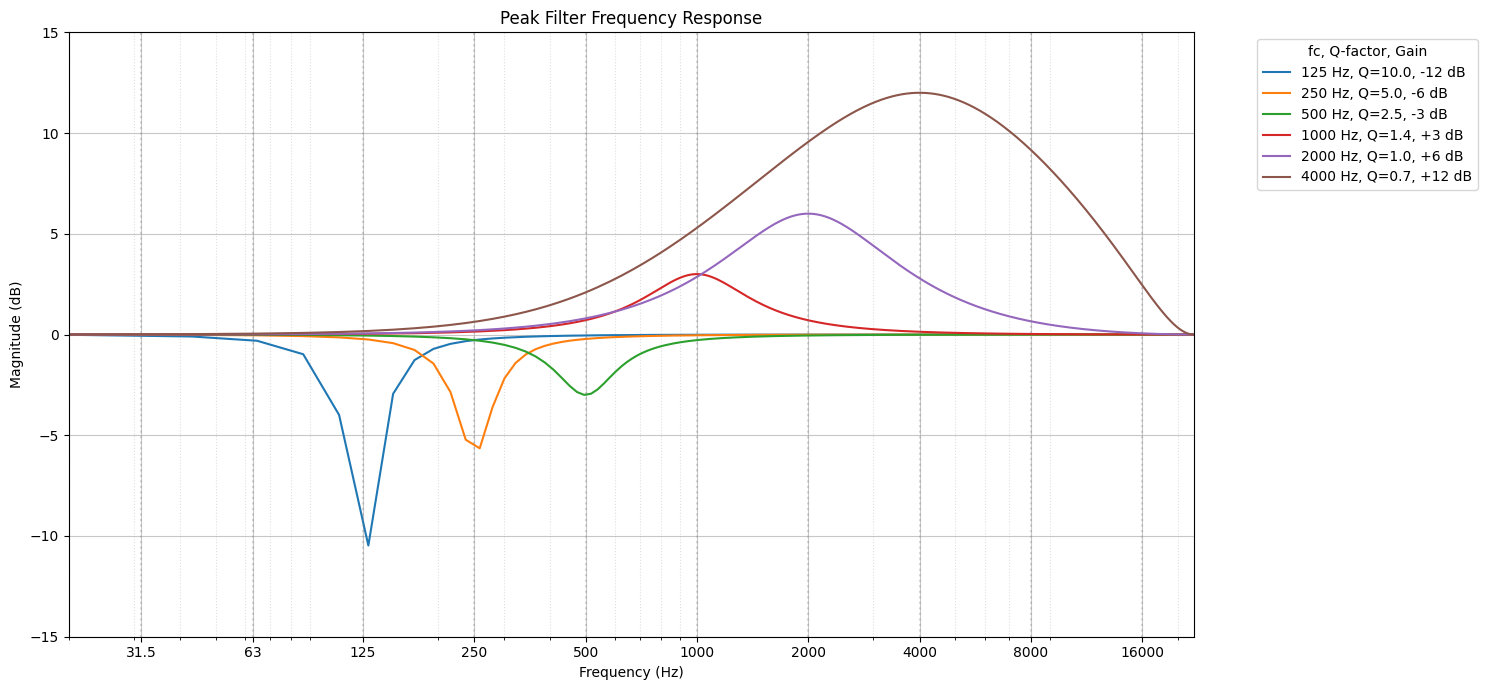

In [165]:
def peak_coefs(G, fc, fb, fs):
    wfc = 2 * fc / fs
    wfb = 2 * fb * fc / fs  # bandwidth is a ratio of the fc
    
    V_0 = 10 ** (G / 20)
    H_0 = V_0 - 1
    
    tan = np.tan(np.pi * wfb / 2)  
    
    if G >= 0:
        c = (tan - 1) / (tan + 1)
    else:
        c = (tan - V_0) / (tan + V_0)
        
    d = -np.cos(np.pi * wfc)
    return d, V_0, H_0, c

def peak_filter(x, G, fc, fb, fs):
    N = len(x)
    y = np.zeros(N)
    xh = np.zeros(2)  # optimizing a bit x_h in this example
    
    d, V_0, H_0, c = peak_coefs(G, fc, fb, fs)
    
    for n in range(N):
        xh_new = x[n] - d * (1-c) * xh[0] + c * xh[1]

        # all pass y
        ap_y = -c * xh_new + d * (1-c) * xh[0] + xh[1]
        
        xh[1] = xh[0]
        xh[0] = xh_new
        
        y[n] = 0.5 * H_0 * (x[n] - ap_y) + x[n]
    
    return y


def peak_filter_freq_response(G, fc, fb, fs, n_points=1024):
    w = np.linspace(0, np.pi, n_points)
    H = np.zeros_like(w, dtype=complex)

    d, V_0, H_0, c = peak_coefs(G,fc,fb,fs)

    for i, omega in enumerate(w):
        z = np.exp(1j * omega)

        num = -c + d * (1 - c) * z**-1 + z**-2
        den =  1 + d * (1 - c) * z**-1 - c * z**-2
        a_z = num /den
        
        H[i] = 1 + 0.5 * H_0 * (1 - a_z)

    freqs = (w * fs) / (2 * np.pi)

    return freqs, 20 * np.log10(np.abs(H))


cutoffs = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]  # Standard ISO frequencies

# Test parameters
gains = [-12, -6, -3, 3, 6, 12]  
bandwidths = [0.1, 0.2, 0.4, 0.7, 1.0, 1.5]  
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  

print("Original")
display(Audio(samples, rate=fs))

plt.figure(figsize=(15, 7))

for G, color, fc, fb in zip(gains, colors, cutoffs[2:8], bandwidths):
    freqs, mags = peak_filter_freq_response(G, fc, fb, fs)
    plt.plot(freqs, mags, linestyle='-', color=color, 
             label=f"{fc:g} Hz, Q={1/fb:.1f}, {G:+d} dB")

    print(f"G={G}, fc={fc}, fb={fb}")
    filtered = peak_filter(samples, G, fc, fb, fs)
    display(Audio(filtered, rate=fs))


# vertical lines at standard octave frequencies
for f in cutoffs:
    if 20 <= f <= fs/2:
        plt.axvline(f, color='gray', linestyle=':', alpha=0.3)

plt.xscale('log')
plt.xlim(20, fs/2)
plt.ylim(-15, 15)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Peak Filter Frequency Response")
plt.legend(title="fc, Q-factor, Gain", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="major", ls="-", alpha=0.7)
plt.grid(True, which="minor", ls=":", alpha=0.4)
plt.xticks(cutoffs, [f"{f:g}" for f in cutoffs])
plt.tight_layout()
plt.show()

G = 10
fb = 0.1 # ratio of fc
fc = 1000
